In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

from torch.utils.data import Subset

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [23]:
train_transform = transforms.Compose([
    transforms.Resize((224, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [24]:
data_dir = "/kaggle/input/5-flower-types-classification-dataset/flower_images"

train_data_full = datasets.ImageFolder(root=data_dir, transform=train_transform)
test_data_full = datasets.ImageFolder(root=data_dir, transform=test_transform)


In [41]:
classes = train_data_full.classes

In [25]:
num_images = len(train_data_full)

indices = list(range(num_images))
np.random.shuffle(indices)

print(num_images)

4999


In [32]:
4999*0.2

999.8000000000001

In [26]:
# 80% Train, 20% Test
split = int(np.floor(0.2 * num_images))

train_indices = indices[split:]
test_indices = indices[:split]

print(split)

999


In [27]:
train_dataset = Subset(train_data_full, train_indices)
test_dataset = Subset(test_data_full, test_indices)

In [28]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training images: {len(train_dataset)}\nTesting images: {len(test_dataset)}")

Training images: 4000
Testing images: 999


In [29]:
class FlowerCNN(nn.Module):
    def __init__(self):
        super(FlowerCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2) 
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2) 
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2) 
        
        self.flatten = nn.Flatten()
        
        
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5) 
        self.fc2 = nn.Linear(512, 5) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x

In [30]:
model = FlowerCNN().to(device)

In [31]:

LR = 0.001
EPOCHS = 7
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.0001)


In [32]:
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train() 
    running_train_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad() 
        loss.backward()       
        optimizer.step()    
        
        running_train_loss += loss.item()
    
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval() 
    running_test_loss = 0.0
    
    with torch.no_grad(): 
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            
    
    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

Epoch 1/7 | Train Loss: 1.2731 | Test Loss: 1.1626
Epoch 2/7 | Train Loss: 1.0739 | Test Loss: 1.0373
Epoch 3/7 | Train Loss: 0.9894 | Test Loss: 0.9925
Epoch 4/7 | Train Loss: 0.9102 | Test Loss: 0.9226
Epoch 5/7 | Train Loss: 0.8391 | Test Loss: 0.9324
Epoch 6/7 | Train Loss: 0.7857 | Test Loss: 0.8597
Epoch 7/7 | Train Loss: 0.7376 | Test Loss: 0.8309


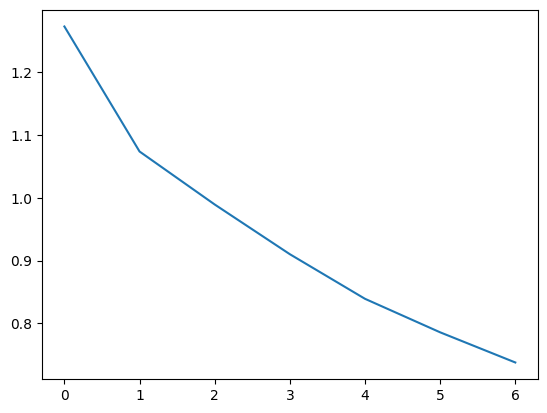

In [33]:
plt.plot(train_losses)

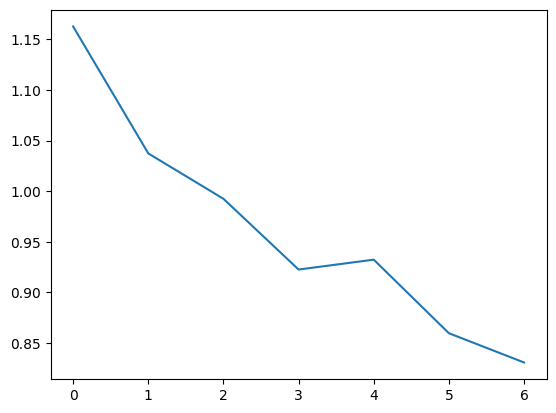

In [34]:

plt.plot(test_losses)

In [35]:
model.eval() 
correct = 0
total = 0

with torch.no_grad(): 
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Testing Accuracy: {accuracy:.2f}%")

Testing Accuracy: 77.20%


In [36]:
model.eval() 
correct = 0
total = 0

with torch.no_grad(): 
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Testing Accuracy: {accuracy:.2f}%")

Testing Accuracy: 68.47%


In [37]:
def get_all_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = [] 

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            
         
            probs = F.softmax(outputs, dim=1)
            
            _, preds = torch.max(outputs, 1)
           
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

In [38]:
y_pred, y_true, y_probs = get_all_predictions(model, test_loader)

Text(0.5, 1.0, 'Confusion Matrix')

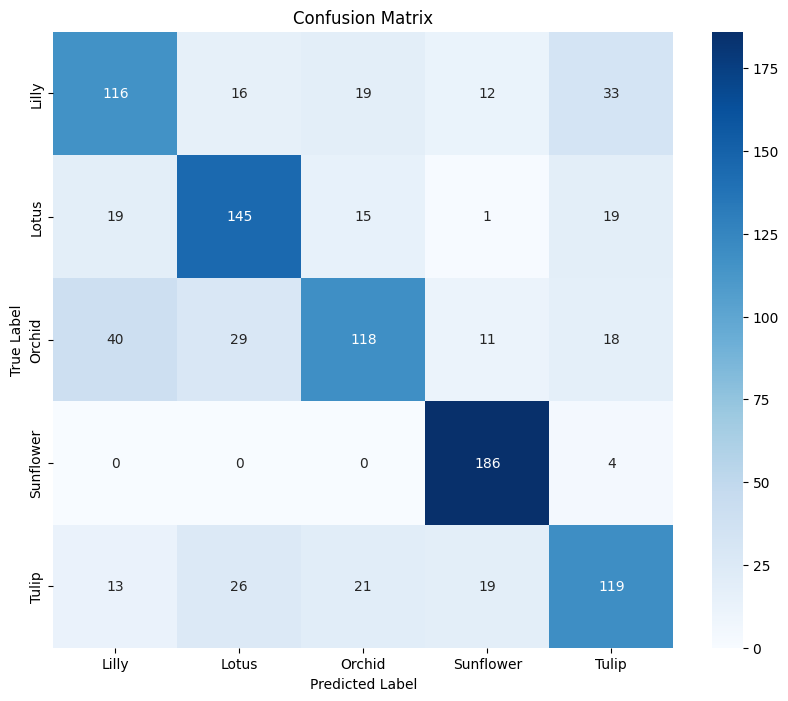

In [42]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


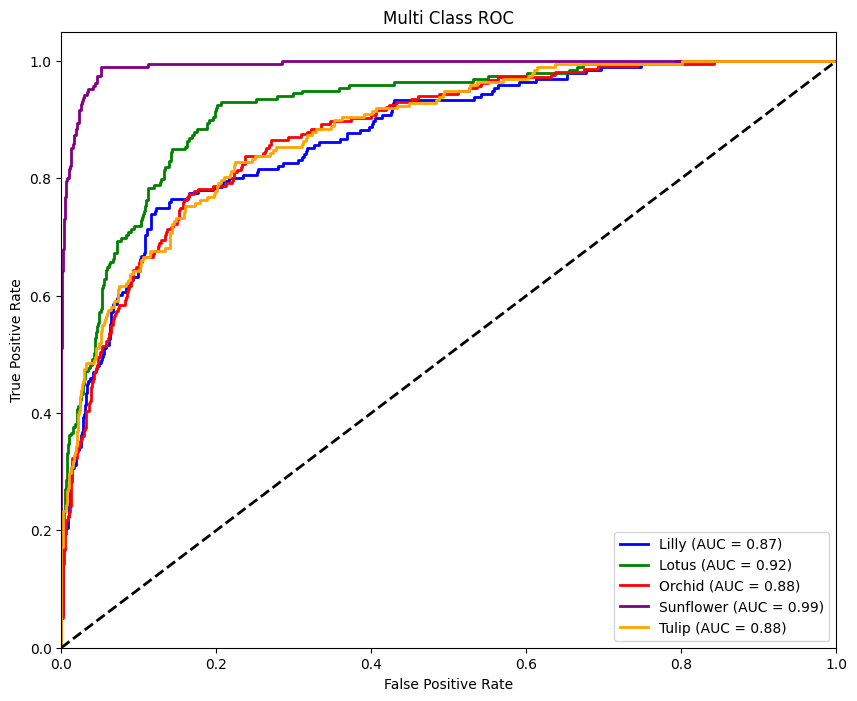

In [43]:
y_true_bin = label_binarize(y_true, classes=range(len(classes)))
n_classes = len(classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi Class ROC')
plt.legend(loc="lower right")
plt.show()

In [56]:
images, labels = next(iter(test_loader))
single_img = images[2].unsqueeze(0).to(device)

In [49]:
single_img.shape

torch.Size([1, 3, 128, 128])

In [57]:
model.eval()
with torch.no_grad():
    feature_maps = model.relu1(model.conv1(single_img))

# feature_maps = feature_maps.squeeze(0).cpu()
# feature_maps.shape

feature_maps

torch.Size([16, 128, 128])

In [59]:
model.eval()
with torch.no_grad():
    feature_maps = model.relu2(model.conv2(feature_maps))

# feature_maps = feature_maps.squeeze(0).cpu()
# feature_maps.shape


torch.Size([32, 128, 128])

In [62]:
model.eval()
with torch.no_grad():
    feature_maps = model.relu3(model.conv3(feature_maps))

# feature_maps = feature_maps.squeeze(0).cpu()
# feature_maps.shape


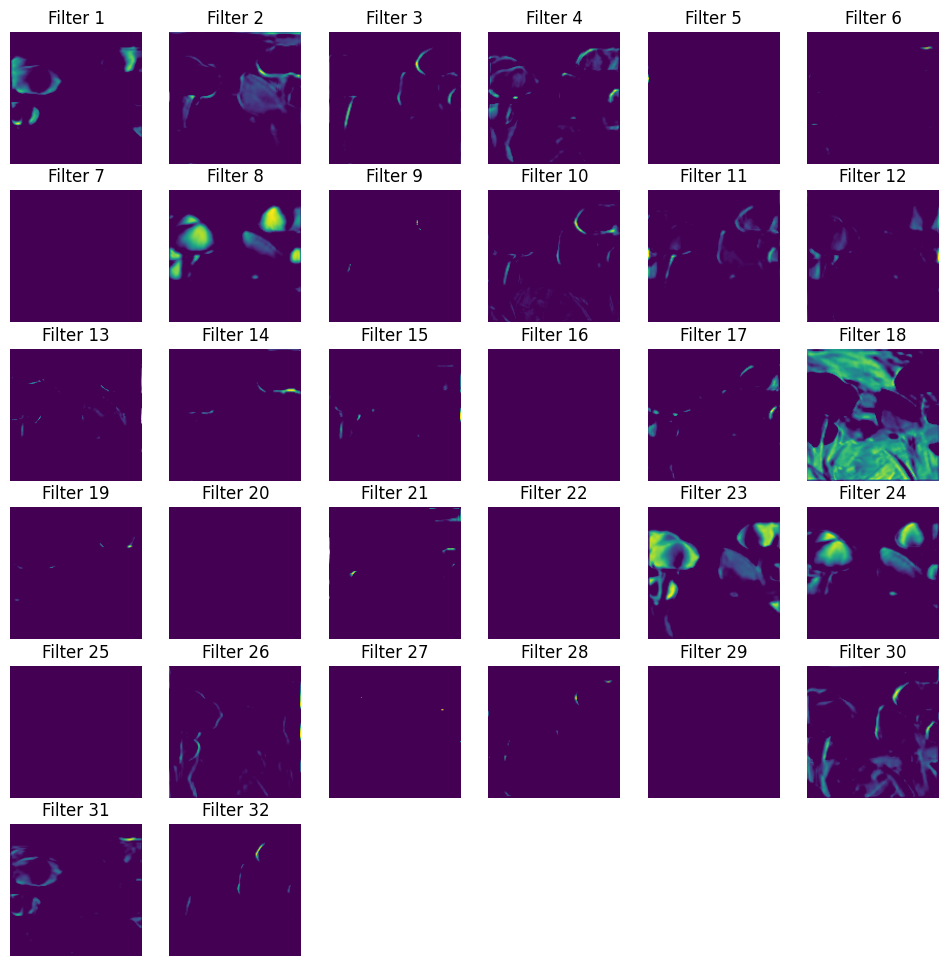

In [63]:
plt.figure(figsize=(12, 12))
for i in range(32): 
    plt.subplot(6, 6, i+1) 
    plt.imshow(feature_maps[i], cmap='viridis') 
    plt.axis('off')
    plt.title(f"Filter {i+1}")



In [ ]:
# def predict_image(image_path, model, classes):
#     from PIL import Image
    
#     image = Image.open(image_path)
 
#     image_tensor = transform(image).unsqueeze(0).to(device)
    
#     model.eval()
#     with torch.no_grad():
#         output = model(image_tensor)
#         _, predicted_idx = torch.max(output, 1)
#         predicted_class = classes[predicted_idx.item()]
        
#     return predicted_class


Final Prediction: Lotus


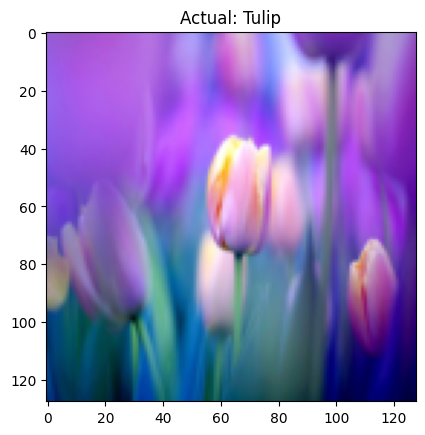

In [64]:
sample_img, sample_label = test_dataset[0] 

inv_normalize = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[2, 2, 2]
)
sample_img_inv = inv_normalize(sample_img)


plt.imshow(sample_img_inv.permute(1, 2, 0)) 
plt.title(f"Actual: {classes[sample_label]}")


sample_input = sample_img.unsqueeze(0).to(device)
with torch.no_grad():
    out = model(sample_input)
    _, pred = torch.max(out, 1)
    print(f"\nFinal Prediction: {classes[pred.item()]}")